In [1]:
pip install boto3 numpy scikit-image matplotlib imageio sklearn opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 132 kB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 87.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 107.4 MB/s eta 0:00:01
     |████████████████████████████████| 60.9 MB 81.8 MB/s eta 0:00:01
     |████████████████████████████████| 8.9 MB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 24.1 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 99.2 MB/s eta 0:00:01
     |████████████████████████████████| 930 kB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 106.3 MB/s eta 0:00:01
     |████████████████████████████████| 38.1 MB 106.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 70.4 MB/s eta 0:00:01
     |████████████

In [30]:
import numpy as np                 # librería para manejar las matrices resultantes de las imágenes 
import matplotlib.pyplot as plt    # librería para visualizar los datos
from skimage.color import rgb2gray # librería para cambiar a escala de grises las imágenes
import imageio                     # librería para cargar la imagen
from sklearn import preprocessing  # Para utilizar LabelEncoder()
import cv2 as cv                   # Para darle un suavizado a la imagen
from sklearn.decomposition import PCA as RandomizedPCA # PCA
from sklearn.preprocessing import scale # Para estadarizar los datos
from os import listdir,walk
import os.path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [2]:
#path2 = "D:\\noveno_semestre\\proyecto\\confirmed_fronts"
import boto3

bucket = 'proyecto-integrador-raw'

s3 = boto3.resource('s3')
my_bucket = s3.Bucket('proyecto-integrador-raw')
    
car_list = set([f.key for f in my_bucket.objects.filter(Prefix="confirmed_fronts/")])

In [3]:
car_select = set(['Alfa Romeo','Audi','Chevrolet',
              'Honda', 'Hyundai','Mazda','Nissan',
                  'Toyota'])

# car_select = set(['Hyundai','Mazda','Nissan',
#                  'Toyota'])

cars = car_list.intersection(car_select)
car_final = []

for file in car_list:
    for car in car_select:
        if car in file:
            car_final.append(file)



In [4]:
y_car = [] 
x_car = []

s3_client = boto3.client('s3')
                
for file in car_final:
    if file.endswith(".jpg"):
        obj = s3_client.get_object(Bucket='proyecto-integrador-raw', Key=file)
        x_car.append(obj["Body"].read())
        y_car.append(file.split("/")[1])


In [5]:
X = [rgb2gray(imageio.v2.imread(f)) for f in x_car] # Esto se demora 3 min aprox, porque convierte las imagenes a array
le = preprocessing.LabelEncoder()
Y = le.fit_transform(y_car)
print("El data set cuenta con {} imágenes".format(len(Y)))
print("Cada imágen con una dimensión {}".format(np.array(X[0]).shape))


El data set cuenta con 19020 imágenes
Cada imágen con una dimensión (300, 300)


In [6]:
# For show images - para mirar las imagenes
def plot_image(img: np.array):
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray');
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray');

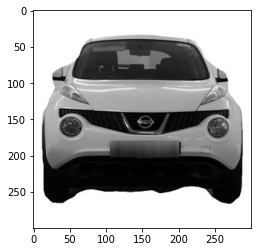

In [7]:
imgplot = plt.imshow(X[5], cmap=plt.cm.gray)
plt.show()

# Preparación de datos

## Aprendizaje de características


La ingeniería de características o la extracción de características es el proceso de extraer patrones útiles de los datos de entrada que ayudarán al modelo de predicción a comprender mejor la naturaleza real del problema. Un buen aprendizaje de características presentará patrones de una manera que aumente significativamente la precisión y el rendimiento de los algoritmos de aprendizaje automático aplicados de una manera que sería imposible o demasiado costosa para el propio aprendizaje automático. Los algoritmos de aprendizaje de características encuentran los patrones comunes que son importantes para distinguir entre las clases deseadas y los extraen automáticamente. Después de este proceso, están listos para ser utilizados en un problema de clasificación o regresión.
Consideremos un problema popular de clasificación de imágenes, clasificación de imágenes de un rostro y un objeto sin rostro. En los primeros días de la visión por computadora, los científicos intentaron resolver el problema codificando a mano los algoritmos de detección de las posibles características de un rostro humano, como la forma, los ojos, la nariz, los labios, etc. muchas variedades, que no fue posible dar cuenta ni siquiera de una fracción significativa de las características. Solo un simple cambio en la iluminación o la orientación puede provocar un cambio en una imagen de modo que los algoritmos ya no puedan detectar rostros.
En 1998, Yann Lecun introdujo el concepto de redes neuronales convolucionales, que era capaz de clasificar imágenes de caracteres escritos a mano con una precisión de aproximadamente el 99%. La gran ventaja de las redes neuronales convolucionales es que son excepcionalmente buenas para encontrar características en imágenes que crecen después de cada nivel, lo que al final da como resultado características de alto nivel. Las capas finales (pueden ser una o más) utilizan todas estas características generadas para clasificación o regresión.
Circunvolución
La convolución es una operación que se realiza en una imagen para extraer características de ella aplicando un tensor más pequeño llamado kernel como una ventana deslizante sobre la imagen. Dependiendo de los valores en el kernel convolucional, podemos seleccionar patrones específicos de la imagen. En el siguiente ejemplo, demostraremos la detección de bordes horizontales y verticales en una imagen usando kernels apropiados.

In [8]:
# Dectecting features in images  
# let img1 be an image with no features


arr2 = np.array([2 for i in range(300)])
arr_2 = np.array([-2 for i in range(300)])

arr2_2 = np.array([2 if i < 150 else -2 for i in range(300)])

kernel_horizontal = np.array([arr2 if i < 150 else arr_2 for i in range(300)])
print(kernel_horizontal, 'is a kernel for detecting horizontal edges')
  
kernel_vertical = np.array([arr2_2 for i in range(300)])
print(kernel_vertical, 'is a kernel for detecting vertical edges')
  
# We will apply the kernels on the images by
# elementwise multiplication followed by summation
def apply_kernel(img, kernel):
    return np.sum(np.multiply(img, kernel))

feautures = []
for img, title in zip(X, y_car):
    feautures.append({"img": img, "title": title, "horizontal": apply_kernel(img, kernel_horizontal), "vertical": apply_kernel(img, kernel_vertical)})


[[ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 ...
 [-2 -2 -2 ... -2 -2 -2]
 [-2 -2 -2 ... -2 -2 -2]
 [-2 -2 -2 ... -2 -2 -2]] is a kernel for detecting horizontal edges
[[ 2  2  2 ... -2 -2 -2]
 [ 2  2  2 ... -2 -2 -2]
 [ 2  2  2 ... -2 -2 -2]
 ...
 [ 2  2  2 ... -2 -2 -2]
 [ 2  2  2 ... -2 -2 -2]
 [ 2  2  2 ... -2 -2 -2]] is a kernel for detecting vertical edges


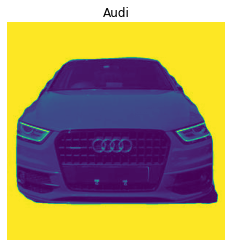

Horizontal edge confidence score: 16031.572725490194
Vertical edge confidence score: -572.246916862745


In [9]:
# Visualizing img1
plt.imshow(feautures[0]["img"])
plt.axis('off')
plt.title(feautures[0]["title"].replace("$",""))
plt.show()

# Checking for horizontal and vertical features in image1
print('Horizontal edge confidence score:', feautures[0]["horizontal"])
print('Vertical edge confidence score:', feautures[0]["vertical"])

In [10]:
print('Horizontal edge confidence average score:', sum(i["horizontal"] for i in feautures)/len(feautures))
print('Vertical edge confidence average score:', sum(i["vertical"] for i in feautures)/len(feautures))

Horizontal edge confidence average score: 16279.55648187755
Vertical edge confidence average score: 231.34799671722203


## Convolutions

In [11]:
# Convolusiones que aplicaremos
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

In [12]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

In [13]:
# Calcular numero de pixeles
calculate_target_size(300, 3)

298

In [14]:
# Aplicando una pequeña convolucion a una parte de la imagen 1
pixel_init = 100
sub_set = X[0][pixel_init:pixel_init + 3,pixel_init:pixel_init + 3]
sub_set

array([[0.23043608, 0.23043608, 0.23043608],
       [0.25901804, 0.25845255, 0.25901804],
       [0.25844471, 0.26096745, 0.25844471]])

In [15]:
np.multiply(sub_set, sharpen)

array([[ 0.        , -0.23043608,  0.        ],
       [-0.25901804,  1.29226275, -0.25901804],
       [ 0.        , -0.26096745,  0.        ]])

In [16]:
np.sum(np.multiply(sub_set, sharpen))

0.28282313725490216

In [17]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

In [18]:
img_sharpened = convolve(img=X[0], kernel=sharpen)
img_sharpened

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

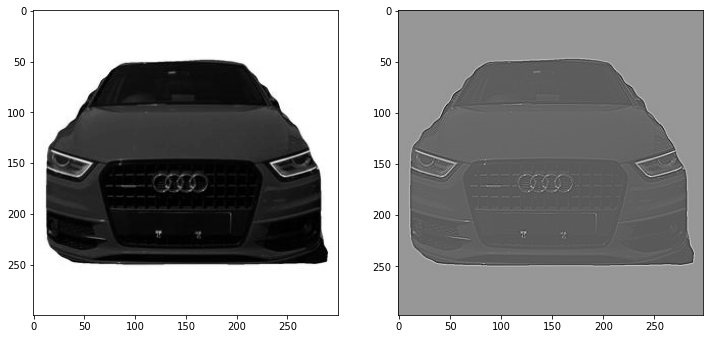

In [19]:
# Visualizamos la imagen luego de la convolusion (convolusion de agudizamiento)
plot_two_images(
    img1=X[0], 
    img2=img_sharpened
)

In [23]:
# X_sharpened = [convolve(img=img, kernel=sharpen) for img in X]
# X_blur = [convolve(img=img, kernel=sharpen) for img in X]
# X_outline = [convolve(img=img, kernel=sharpen) for img in X]

# PCA

In [20]:
train_dataset = np.array(X)
nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny)) # Se convierten los datos en un vector

In [21]:
pca = RandomizedPCA(150)
pca.fit(d2_train_dataset)

PCA(n_components=150)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.1504855  0.13411221 0.06529339 0.04520547 0.03509873 0.02446915
 0.01893222 0.01700093 0.01676499 0.01335019 0.01292399 0.01087892
 0.00995994 0.00892708 0.00827406 0.00754675 0.0069622  0.00674996
 0.00658368 0.00600113 0.00556266 0.00533389 0.00482599 0.00467341
 0.00443385 0.00417121 0.00402468 0.00396322 0.00375224 0.00363559
 0.00335399 0.00331897 0.00306167 0.00290432 0.00282391 0.00275925
 0.00267497 0.00257511 0.00246028 0.00233459 0.00225194 0.00224058
 0.00214987 0.00209851 0.00204433 0.00201684 0.00196658 0.0019246
 0.00186772 0.00180502 0.00179441 0.00172173 0.0016919  0.00166816
 0.00164198 0.00161255 0.00155388 0.00151126 0.00149433 0.00146656
 0.00145512 0.00142394 0.00139564 0.00139467 0.00135976 0.00132918
 0.00132178 0.00131387 0.00125302 0.00123747 0.00120568 0.0011972
 0.00118102 0.00115824 0.00113647 0.001

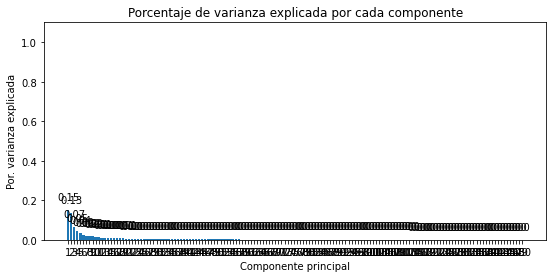

In [22]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.1504855  0.28459771 0.3498911  0.39509656 0.43019529 0.45466444
 0.47359666 0.49059759 0.50736258 0.52071277 0.53363676 0.54451568
 0.55447562 0.56340271 0.57167677 0.57922352 0.58618573 0.59293569
 0.59951937 0.6055205  0.61108316 0.61641705 0.62124304 0.62591645
 0.6303503  0.63452151 0.63854619 0.64250941 0.64626166 0.64989725
 0.65325123 0.6565702  0.65963187 0.66253619 0.66536011 0.66811936
 0.67079433 0.67336944 0.67582972 0.67816431 0.68041625 0.68265683
 0.6848067  0.6869052  0.68894954 0.69096637 0.69293296 0.69485756
 0.69672528 0.6985303  0.70032471 0.70204643 0.70373833 0.70540649
 0.70704847 0.70866102 0.7102149  0.71172616 0.71322049 0.71468706
 0.71614218 0.71756612 0.71896176 0.72035643 0.72171619 0.72304537
 0.72436716 0.72568103 0.72693405 0.72817152 0.7293772  0.7305744
 0.73175542 0.73291365 0.73405012 0.73518563 0.7363022  0.73741161
 

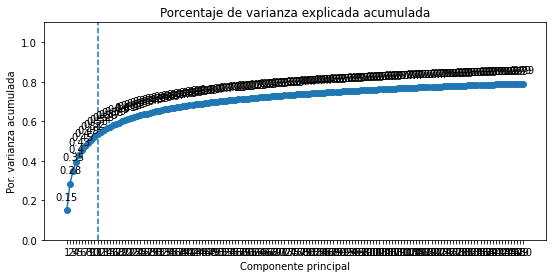

In [23]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.plot(
    np.arange(pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(pca.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.axvline(x=11, linestyle = '--')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [24]:
img_size = 300

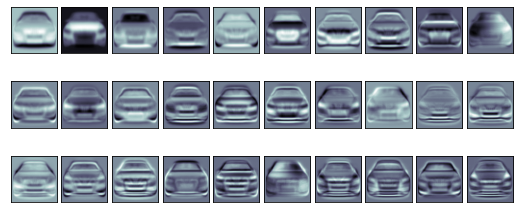

In [25]:
fig, axes = plt.subplots(3, 10, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(img_size, img_size), cmap='bone')

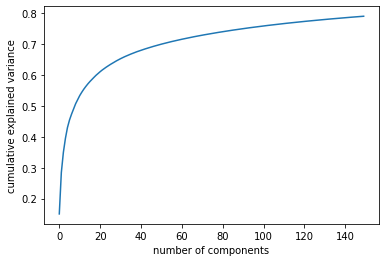

In [26]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [27]:
pca = RandomizedPCA(150).fit(d2_train_dataset)
components = pca.transform(d2_train_dataset)
projected = pca.inverse_transform(components)

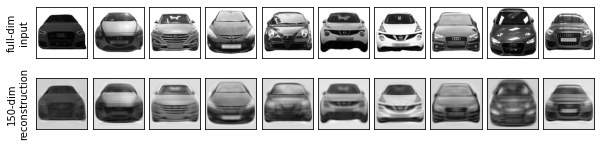

In [28]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10,2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(d2_train_dataset[i].reshape(300, 300), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(300, 300), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

In [29]:
# #split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(d2_train_dataset,Y,test_size=0.3,random_state=0) 
pca = PCA(n_components =150)
# #scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))#[:,:1]

# #train PCR model on training data 
# regr = LogisticRegression()
# regr.fit(X_reduced_train, y_train)

# pred = regr.predict(X_reduced_test)

In [34]:
# X_reduced_test.shape

In [35]:
# X_reduced_train.shape

In [36]:
# scale(d2_train_dataset).shape

In [37]:
# from sklearn.metrics import classification_report, confusion_matrix

# cm = confusion_matrix(y_test, pred, labels=list(set(Y)))
# print("Iteration %i %s" % (i, 70 * "_"))

# print(classification_report(y_test, pred))

# print("Confusion matrix")
# print(cm)

In [31]:
knn_model = KNeighborsClassifier(n_neighbors=8)
knn_model.fit(X_train, y_train)
score = knn_model.score(X_test, y_test)
print(score)

0.7756747283561164


In [32]:
k_range = list(range(1, 16))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn_model, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
grid_model = grid.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
